# QML 1: Running Primitive Unified Blocks (PUBs)

## SamplerV2, EstimatorV2 & Statevector Simulator

This notebook demonstrates how to use **Primitive Unified Blocks (PUBs)** for:

- Sampling the output of a quantum circuit  
- Estimating the expectation value of an observable  

### Key Features Covered

- Both **simple** and **parametric** quantum circuits are illustrated.
- Use of the **Aer Simulator** for:
  - Sampling
  - Expectation value estimation
- Demonstration of running circuits on **IBM Quantum computers** via their **latest cloud platform (announced July 1, 2025 onward)**.
- **Statevector-based sampler and estimator** syntax and implementations are also shown.

### Environment Requirements

If you are running this notebook locally (e.g., **VS Code / Jupyter**), ensure the following libraries are installed:

- `qiskit`
- `qiskit-aer`
- `qiskit-ibm-runtime`
- `matplotlib`
- `pylatexenc`

If you are running this notebook on **Google Colab**, these libraries must be installed **each time you initialize a new Colab session**.



## Step 1: Link Your IBM Quantum Cloud Account

Create an account at **https://quantum.cloud.ibm.com** and log in.

1. Create a new **Instance** from the IBM Quantum dashboard.
2. After creating the instance:
   - Copy the **Instance CRN**
   - Generate and copy your **API Key (token)**
3. In the code cell below, paste the **CRN** and **API key**.
4. You may name your account **anything you prefer**.

> ⚠️ **Important:** Keep your API key private and never share it in public repositories.


In [8]:
from qiskit_ibm_runtime import QiskitRuntimeService
token = "4RQn9uLANeEznd5f2BXfhLzQqYj7I7MGyPGFStopB9TC" # This is API key for IBM Quantum account. Get it from https://quantum-computing.ibm.com/account
QiskitRuntimeService.save_account(
  token=token,
  channel="ibm_cloud", # `channel` distinguishes between different account types.
  instance="crn:v1:bluemix:public:quantum-computing:us-east:a/e423010f57b54abab65ed63e9e7f9927:a9f0c08e-395c-4265-876b-f3a6d34b1617::", # Optionally copy the instance CRN or name from the Instance section on the dashboard.
  name="Muhammad Mudassar", # Optionally name this set of credentials.
  overwrite=True # Only needed if you already have Cloud credentials.
)

## Step 2: Load Your IBM Quantum Credentials

Use the **account name** you defined in Step 1 to load your saved credentials.

Once loaded, you can connect to your desired **IBM Quantum backend**, either a real quantum computer or a simulator, and begin running quantum jobs.


In [9]:
# Load saved credentials if you specified a name
ibm_service = QiskitRuntimeService(name="Muhammad Mudassar")
ibmq_comp = ibm_service.backend('ibm_torino')

### Importing the Aer Simulator

Below, we import the **AerSimulator**, which is used to simulate quantum circuits locally for both sampling and expectation value estimation.


In [10]:
from qiskit_aer import AerSimulator
backend_aer = AerSimulator()

## Step 3: Instantiate Samplers

Import **SamplerV2** from the IBM Quantum Runtime and instantiate it for use with:

- The **Aer Simulator** (local simulation)
- An **IBM Quantum computer** (real hardware)

The **Sampler** primitive is used to **measure (sample)** the output of a quantum circuit a specified number of times (shots), returning the probability distribution of measurement outcomes.


In [11]:
from qiskit_ibm_runtime import SamplerV2
sampler_aer = SamplerV2(mode=backend_aer)
sampler_ibm = SamplerV2(mode=ibmq_comp)

## Create a Quantum Circuit for Sampling

In this step, we create a quantum circuit whose output will be **sampled using the Sampler primitive**.  
The circuit will include quantum gates followed by measurements to obtain classical outcomes.


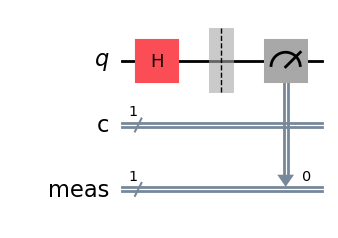

In [12]:
from qiskit import QuantumCircuit
qc1 = QuantumCircuit(1,1)
qc1.h(0)
qc1.measure_all()
qc1.draw('mpl')

## Step 4: Parametric Quantum Circuit

Create a **parametric quantum circuit** using your chosen names for the **quantum registers** and **classical registers**.

These register names are later used to:
- Access specific **qubits**
- Access specific **classical bits**
- Bind parameters when running the circuit with different values


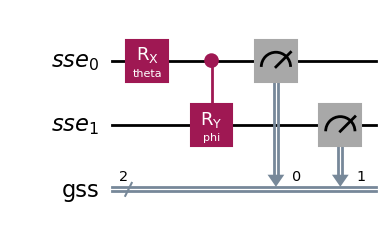

In [13]:
from qiskit import QuantumRegister, ClassicalRegister
from qiskit.circuit import Parameter
from qiskit import QuantumCircuit
qr = QuantumRegister(2, name='sse')
cr = ClassicalRegister(2, name='gss')
theta=Parameter('theta')
phi=Parameter('phi')
qc2 = QuantumCircuit(qr, cr)
qc2.rx(theta, 0)
qc2.cry(phi, 0, 1)
qc2.measure(qr,cr)
qc2.draw('mpl')

### Checking the Parameter Order

To verify the **order of parameters** defined in the parametric circuit, use the following method.


In [14]:
qc2.parameters

ParameterView([Parameter(phi), Parameter(theta)])

### Create an Array of Parameter Sets

Create an **array of arrays** containing parameter values.  
Each inner array corresponds to one complete set of parameters for the parametric circuit and will be used when running the sampler.


In [15]:
from math import pi
angles = [[pi/2, pi/4], [pi/3, pi/6], [pi/4, pi/8], [pi/5, pi/10]]

## Step 5a: Transpile the Circuit for the Simulator

Transpile the quantum circuit to make it compatible with the **desired simulator backend**.

This step optimizes the circuit and maps it to the gate set supported by the simulator, ensuring efficient and correct execution.


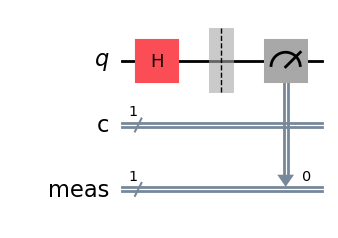

In [16]:
from qiskit import transpile
qc1_aer = transpile(qc1, backend_aer)
qc1_aer.draw('mpl')

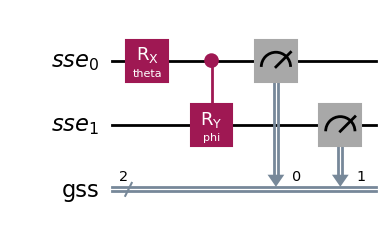

In [17]:
qc2_aer = transpile(qc2, backend=backend_aer)
qc2_aer.draw('mpl')

## Step 5b: Transpile the Circuit for Quantum Hardware

Transpile the quantum circuit to make it compatible with the **desired IBM Quantum hardware backend**.

This step optimizes the circuit and maps it to the **native gate set and topology** of the hardware, ensuring correct execution on the real quantum device.


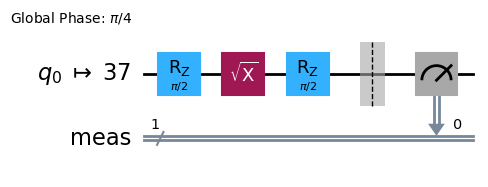

In [18]:
qc1_ibm = transpile(qc1, ibmq_comp)
qc1_ibm.draw('mpl',idle_wires=False)

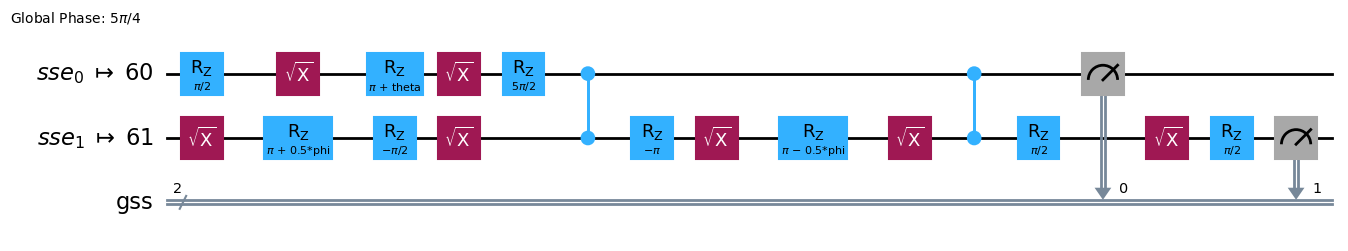

In [19]:
qc2_ibm = transpile(qc2, ibmq_comp)
qc2_ibm.draw('mpl',idle_wires=False)

## Step 6: Primitive Unified Blocks (PUBs)

We now run the **Primitive Unified Blocks (PUBs)** using the following inputs:

- **Transpiled circuit**  
- **Array of parameter sets**  
- **Number of shots**: the number of times the circuit will be executed and sampled

Each PUB execution returns the **measurement outcomes** for all runs, allowing us to analyze probabilities and expectation values efficiently.


In [20]:
job_aer = sampler_aer.run([(qc1_aer,None, 100), (qc2_aer,angles,1000)])  #PUBs on AER simulator
#job_ibm = sampler_ibm.run([(qc1_ibm,None, 100), (qc2_ibm,angles,1000)])    #PUBs on IBM quantum computer

### Retrieve Results from the Job

After running the circuit using a Primitive Unified Block (PUB), use the **`.result()`** method to retrieve the execution results.  

This method provides access to:
- Measurement outcomes  
- Counts or probabilities  
- Any other job-specific data returned by the simulator or hardware


In [21]:
result_aer = job_aer.result()
#result_ibm = job_ibm.result()

## Step 7: Accessing the Results

To access the **measurement counts** from the results:

- Specify the **PUB index** in square brackets `[ ]` (from `0` to `n-1`, if you have `n` PUBs)  
- Specify the **parameter set index** in parentheses `( )` (from `0` to `m-1`, if you have `m` sets of parameters)  

Example notation:



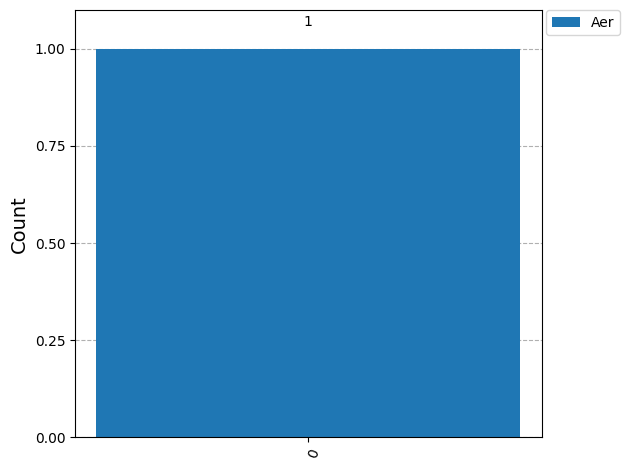

In [22]:
counts_qc1_aer = result_aer[0].data.meas.get_counts(0)
#counts_qc1_ibm = result_ibm[0].data.meas.get_counts(0)


from qiskit.visualization import plot_histogram, plot_distribution
plot_histogram([counts_qc1_aer], legend=['Aer'])

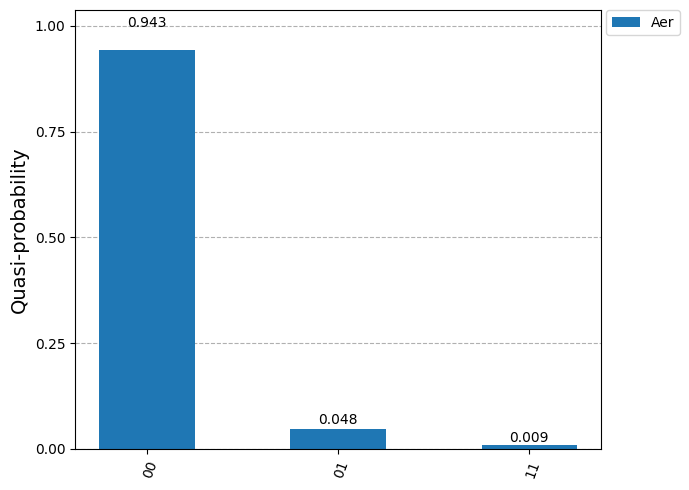

In [23]:
counts_qc2_aer = result_aer[1].data.gss.get_counts(1)
#counts_qc2_ibm = result_ibm[1].data.gss.get_counts(1)

plot_distribution([counts_qc2_aer], legend=['Aer'])


# Using EstimatorV2 with IBM Quantum and Aer Simulator

This section demonstrates how to use **EstimatorV2** for **estimating expectation values** of observables on both local simulators and IBM Quantum hardware.

---

## Step 1: Observables Definition

Using **`SparsePauliOp`**, you can define **Pauli observables** by specifying them as strings of Pauli operators.  

For example, `"XIZ"` represents a 3-qubit observable applying `X` to qubit 0, `I` (identity) to qubit 1, and `Z` to qubit 2.


In [24]:
from qiskit.quantum_info import SparsePauliOp
obsv_list = [[SparsePauliOp(["XX"],[1])],[SparsePauliOp(["ZZ"],[1])]]


## Step 2: Map Observable Layout

When transpiling a circuit for quantum hardware, the **transpiler maps logical qubits to physical qubits** on the device.  

To correctly estimate expectation values, you must **map your logical observables** to the same qubits as used in the transpiled circuit.  

**Procedure:**
1. Extract the **circuit layout** after transpilation.
2. Reorder or map your observables to match the **physical qubit assignment**.


In [25]:
layout = qc2_ibm.layout

obsv_ibm = [[obsv_list[0][0].apply_layout(layout)],[obsv_list[1][0].apply_layout(layout)]]
obsv_ibm

[[SparsePauliOp(['IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIXXIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII'],
                coeffs=[1.+0.j])],
 [SparsePauliOp(['IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII'],
                coeffs=[1.+0.j])]]

## Step 3: Using EstimatorV2

Import and instantiate **EstimatorV2** to estimate the **expectation values** of your observables.

- Specify the **mode of operation** (e.g., using the **Aer simulator** locally or an **IBM Quantum backend**)  
- EstimatorV2 takes as input:
  - The **transpiled circuit**
  - The **observables** (e.g., `SparsePauliOp`)
  - Optional **parameter values** for parametric circuits

This primitive allows you to efficiently compute expectation values without performing full sampling.


In [26]:
from qiskit_ibm_runtime import EstimatorV2
estimator_aer = EstimatorV2(mode=backend_aer)
estimator_ibm = EstimatorV2(mode=ibmq_comp)

## Step 4. Estimator PUBs
Specify the **Estimator blocks** as:

- **Transpiled circuit**
- **Mapped observables**
- **Array of parameter sets**
- **Tolerance in expectation value**

> **Note:**  
> The number of times the circuit is executed to estimate the expectation value is proportional to  
> **tolerance⁻²**.  
>
> For example, a tolerance of **0.005** requires approximately **40,000** shots.


In [28]:
job2_aer = estimator_aer.run([(qc2_aer,obsv_list,angles, 0.005)])
#job2_ibm = estimator_ibm.run([(qc2_ibm,obsv_ibm,angles, 0.05)])

You can extract the **expectation values** using the `.evs` method by specifying the **PUB index**.


In [29]:
exp_vals_aer = job2_aer.result()[0].data.evs
print(exp_vals_aer)

[[ 5.0000e-04  4.3500e-03  4.9500e-03 -2.5000e-04]
 [ 8.5425e-01  8.9935e-01  9.3725e-01  9.5675e-01]]


If you submitted a job to a quantum computer some time ago, you can access its results by specifying the **job ID** as follows.


In [30]:
#job2_ibm=QiskitRuntimeService().job('csy5rwbe88ng008q7bc0')

In [31]:
#exp_vals_ibm = job2_ibm.result()[0].data.evs
#print(exp_vals_ibm)

You can also check the **standard deviation** of the expectation values in the results using the `.stds` method.


In [32]:
job2_aer.result()[0].data.stds

array([[0.005     , 0.00499995, 0.00499994, 0.005     ],
       [0.00259931, 0.00218615, 0.00174329, 0.00145456]])

In [33]:
#job2_ibm.result()[0].data.stds


# Using the Statevector Simulator for Sampling and Expectation Value Estimation

This section demonstrates how to use the **Statevector Simulator** to:
- Sample the output of quantum circuits
- Estimate the expectation values of observables

---

## Step 1: Import and Instantiate the Statevector Sampler and Estimator

In this step, import and instantiate the **Statevector Sampler** and **Statevector Estimator** to perform sampling and expectation value estimation using exact statevector simulation.


In [35]:
from qiskit.primitives import StatevectorSampler, StatevectorEstimator
SVsampler = StatevectorSampler()
SVestimator = StatevectorEstimator()

## Step 2: Run the Statevector Sampler

Directly run the **Statevector Sampler** using the same **PUB syntax** as before.

The execution and result-access patterns remain unchanged, allowing you to run the circuit and retrieve the results in the same way as with Aer Simulator and IBM Quantum backends.


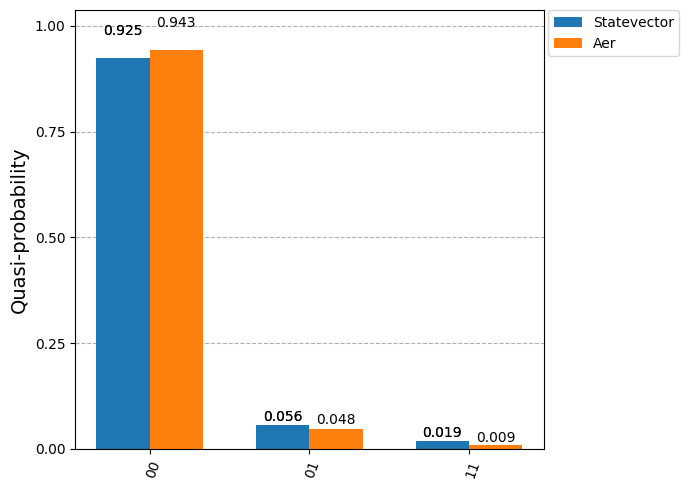

In [36]:
job_svs = SVsampler.run([(qc2,angles,1000),(qc2,angles,100)])
result_svs = job_svs.result()
counts_svs = result_svs[0].data.gss.get_counts(1)
plot_distribution([counts_svs, counts_qc2_aer], legend=['Statevector', 'Aer'])

## Step 3: Remove Measurements for the Statevector Estimator

The **Statevector Estimator** does not work if measurement operations are present at the end of the circuit.

Therefore:
- Remove the **measurement gates** from the `qc2` circuit.
- Redraw the circuit after removing the measurements before using it with the Statevector Estimator.


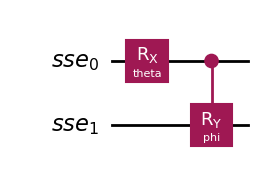

In [37]:
from qiskit import QuantumRegister
from qiskit.circuit import Parameter
from qiskit import QuantumCircuit
qr = QuantumRegister(2, name='sse')

qc2 = QuantumCircuit(qr)
qc2.rx(Parameter('theta'), 0)
qc2.cry(Parameter('phi'), 0, 1)
qc2.draw('mpl')

## Step 4: Run the Circuit with the Statevector Estimator

Directly run the circuit using the same **PUB syntax** as used previously for **EstimatorV2**.

The execution workflow and result-access pattern remain the same, with the only difference being that the computation is performed using **statevector simulation**.


In [38]:
job_sve = SVestimator.run([(qc2,obsv_list,angles,0.005)])
result_sve = job_sve.result()
exp_vals_sve = result_sve[0].data.evs

Both the **Aer Simulator** and the **Statevector (SV) Simulator** should produce the **same expectation values**.

We can verify this by **plotting the expectation values from both simulators together** against the **index of the parameter sets**.


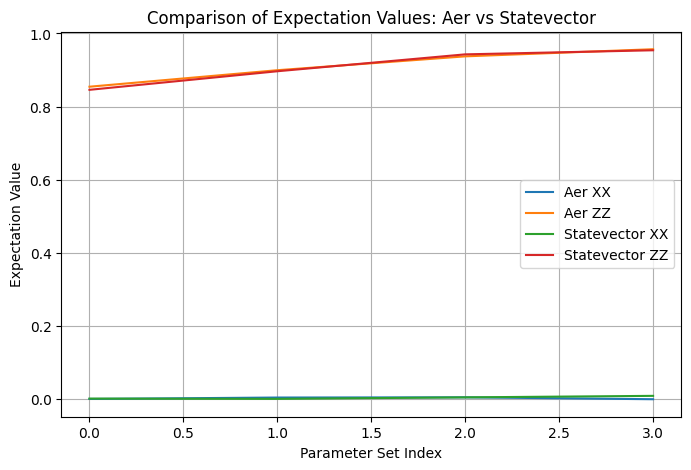

In [39]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
for i, label in enumerate(['Aer', 'Statevector']):
    vals = exp_vals_aer if label == 'Aer' else exp_vals_sve
    plt.plot(vals[0], label=f'{label} XX')
    plt.plot(vals[1], label=f'{label} ZZ')

plt.xlabel('Parameter Set Index')
plt.ylabel('Expectation Value')
plt.title('Comparison of Expectation Values: Aer vs Statevector')
plt.legend()
plt.grid(True)
plt.show()

---

## Acknowledgement and Citation

This notebook is based on materials compiled from **various sources**, with syntax compatible with **Qiskit version 2.3**.

If you use or adapt this notebook in your work, please **cite or acknowledge** the following source:

**Muhammad Mudassar**  
GitHub Repository:  
https://github.com/Mudassar4373/Work

Thank you for acknowledging the original work.
